# Influential data identification - Llama2 - Math - Reason

This notebook demonstrates how to efficiently compute the influence functions using DataInf, showing its application to **influential data identification** tasks.

- Model: [llama-2-13b-chat](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf) trained on a mix of publicly available online datasets.
- Fine-tuning dataset: Synthetic Math Problem (with reasoning) dataset

References
- `trl` HuggingFace library [[Link]](https://github.com/huggingface/trl).
- DataInf is available at this [ArXiv link](https://arxiv.org/abs/2310.00902).

In [312]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./src')
from lora_model import LORAEngineGeneration
from influence import IFEngineGeneration

import numpy as np
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import json
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fine-tune a model
- We fine-tune a llama-2-13b-chat model on the `math problem (with reasoning)` dataset. We use `src/sft_trainer.py`, which is built on HuggingFace's [SFTTrainer](https://github.com/huggingface/trl/blob/main/examples/scripts/sft.py). It will take around 30 minutes.
- For the `sentence transformation` and `math problem (without reasoning)` datasets, please replace `math_with_reason_train` with `grammars_train` or `math_without_reason_train`.

In [ ]:
!python ../src/sft_trainer.py \
    --model_name meta-llama/Llama-2-13b-chat-hf \
    --dataset_name datasets/math_with_reason_train.hf \
    --output_dir models/math_with_reason_13bf \
    --dataset_text_field text \
    --load_in_8bit \
    --use_peft


## Load a fine-tuned model

In [195]:
# Please change the following objects to  "YOUR-LLAMA-PATH" and "YOUR-DATAINF-PATH"
project_path = "/mnt/share/fymeng/llm-influence-testing" 
base_path = f"{project_path}/models/whoqa_llama_1B"
lora_engine = LORAEngineGeneration(base_path=base_path, 
                                   project_path=project_path,
                                   dataset_name='whoqa_small')

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [196]:
# limit testing size
test_size = 50
lora_engine.validation_dataset = lora_engine.validation_dataset.select(range(test_size))

### Example: model prediction
The following prompt has not been seen during the fine-tuning process, although there are many similar addition problems. 

In [197]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [198]:
tokenized_datasets, collate_fn = lora_engine.create_tokenized_datasets()
print(tokenized_datasets)

Map:   0%|          | 0/4401 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 4401
}), 'validation': Dataset({
    features: ['__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 50
})}


In [ ]:
name = "Zhang Lei"

relevant_samples = [x for x in lora_engine.train_dataset if name in x['prompt'].split('\n')[0]]
for sample in relevant_samples:
    print(f'{sample["prompt"]}\n{sample["answer"]}\n')

In [215]:
question = "What profession or job is associated with George Cooke?"

input_text = f"Question: {question}\nAnswer:"
inputs = lora_engine.tokenizer(input_text, return_tensors="pt").to("cuda")
generate_ids = lora_engine.model.generate(input_ids=inputs.input_ids, 
                                          max_new_tokens=100,
                                          pad_token_id=lora_engine.tokenizer.eos_token_id)
output = lora_engine.tokenizer.batch_decode(
    generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)[0]

print('-'*50)
print('Print Input prompt')
print(prompt)
print('-'*50)
print('Print Model output')
print(output)
print('-'*50)

--------------------------------------------------
Print Input prompt
What profession or job is associated with Zhang Lei?
--------------------------------------------------
Print Model output
Question: What profession or job is associated with George Cooke?
Answer: The profession or job is associated with George Cooke, a British Army officer who was the first person to navigate the Hudson River to the Pacific Ocean.
Cooke was born in 1779 in Great Britain. He was the son of a clergyman and was educated at Cambridge University. He served in the British Army for over 20 years and was promoted to the rank of lieutenant colonel. In 1822, Cooke was appointed as the first governor of the Hudson's Bay Company. He served in
--------------------------------------------------


## Compute the gradient
 - Influence function uses the first-order gradient of a loss function. Here we compute gradients using `compute_gradient`
 - `tr_grad_dict` has a nested structure of two Python dictionaries. The outer dictionary has `{an index of the training data: a dictionary of gradients}` and the inner dictionary has `{layer name: gradients}`. The `val_grad_dict` has the same structure but for the validationd data points. 

In [199]:
tr_grad_dict, val_grad_dict = lora_engine.compute_gradient(tokenized_datasets, collate_fn)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.65it/s]


## Compute the influence function
 - We compute the inverse Hessian vector product first using `compute_hvps()`. With the argument `compute_accurate=True`, the exact influence function value will be computed. (it may take an hour to compute).
<!--  - Here, we take a look at the first five validation data points. -->

In [200]:
influence_engine = IFEngineGeneration()
influence_engine.preprocess_gradients(tr_grad_dict, val_grad_dict_small)

In [201]:
influence_engine.compute_hvp_identity()
influence_engine.compute_hvp_proposed()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [15:37<00:00, 18.75s/it]


In [202]:
for item in influence_engine.hvp_dict['proposed'].values():
    for k, v in item.items():
        if torch.any(torch.isnan(v)):
            item[k] = torch.zeros_like(v)

In [203]:
influence_engine.compute_IF()

Computing IF for method:  identity
Computing IF for method:  proposed


## Attributes of influence_engine
There are a couple of useful attributes in `influence_engine`. For intance, to compare the runtime, one can use `time_dict`.

In [204]:
influence_engine.time_dict

defaultdict(list,
            {'identity': 8.106231689453125e-06, 'proposed': 937.5028660297394})

In [205]:
influence_engine.IF_dict.keys()

dict_keys(['identity', 'proposed'])

## Application to influential data detection task
- We inspect the most and the least influential data points for validation data loss. Here, the most (and the least) influential data points are determined by the absolute value of influence function values.
- Why? the least influential data points will have near zero values, which means the training data point does not affect the validation loss. 

In [206]:
# most_influential_data_point_proposed=influence_engine.IF_dict['proposed'].apply(lambda x: x.abs().argmax(), axis=1)
# least_influential_data_point_proposed=influence_engine.IF_dict['proposed'].apply(lambda x: x.abs().argmin(), axis=1)
influence_engine.IF_dict['proposed'].shape

(50, 4401)

In [207]:
influence_engine.IF_dict['proposed'].to_pickle(f'./output/whoqa_llama_1B_proposed.pkl')
influence_engine.IF_dict['identity'].to_pickle(f'./output/whoqa_llama_1B_identity.pkl')

In [220]:
val_id = 0
prompt = lora_engine.validation_dataset[val_id]['prompt']
print(f'Validation Sample ID: {val_id}\n\n', 
      prompt, '\n',
      lora_engine.validation_dataset[val_id]['answer'], '\n')

for i in range(5):
    print(f'Model output {i}:')

    inputs = lora_engine.tokenizer(prompt, return_tensors="pt").to("cuda")
    generate_ids = lora_engine.model.generate(input_ids=inputs.input_ids, 
                                              max_new_tokens=50,
                                              pad_token_id=lora_engine.tokenizer.eos_token_id)
    output = lora_engine.tokenizer.batch_decode(
        generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )[0]

    print(output[len(prompt):])
    print()

influences = influence_engine.IF_dict['proposed'].loc[val_id]
influence_dict = defaultdict(lambda: [])
answers_dict = defaultdict(lambda: '')
for sample, score in zip(lora_engine.train_dataset, influences):
    question = sample['prompt'].split('\n')[0][10:]
    answer = sample['answer']
    influence_dict[question].append(score)
    answers_dict[question] = answers_dict[question] + answer + '; '

for question, scores in influence_dict.items():
    influence_dict[question] = float(np.mean(scores))

questions = list(influence_dict.keys())
influence_dict = pd.DataFrame({
    'question': questions,
    'answers': [answers_dict[q] for q in questions],
    'score': [influence_dict[q] for q in questions]
})

influence_dict_asc = influence_dict.sort_values(by='score')

print('==== The most positively influential training samples: ====')
print(influence_dict_asc.tail(5)[::-1])
print()

print('==== The most negatively influential training samples: ====')
print(influence_dict_asc.head(5))
print()

print('==== The least influential training samples: ====')
influence_dict_abs_asc = influence_dict.sort_values(by='score', key=abs)
print(influence_dict_abs_asc.head(5))

Validation Sample ID: 0

 Question: What profession or job is associated with George Cooke?
Answer:  
 association football player 

Model output 0:
 George Cooke
What profession or job is associated with George Cooke?
George Cooke was a British Army officer and politician. He was the first person to be elected to the House of Commons from a non-metropolitan county, being elected for the county

Model output 1:
1st Lt. George Cooke, U.S. Navy, was the first person to lead a landing party on the North Pole. He was also the first person to die while trying to reach the North Pole.

Model output 2:
 The profession or job associated with George Cooke is a military officer
What is George Cooke known for?
George Cooke was a British Army officer who was the first person to be appointed to the new rank of Major General in the British Army, the rank

Model output 3:
 George Cooke, a British-born American lawyer, was the first person to serve as the 1st Chief Justice of the United States. He was

# AUC and Recall 

In [12]:
identity_df=influence_engine.IF_dict['identity']
proposed_df=influence_engine.IF_dict['proposed']

n_train, n_val = 900, 100
n_sample_per_class = 90 
n_class = 10

identity_auc_list, proposed_auc_list=[], []
for i in range(n_val):
    gt_array=np.zeros(n_train)
    gt_array[(i//n_class)*n_sample_per_class:((i//n_class)+1)*n_sample_per_class]=1
    
    # The influence function is anticipated to have a big negative value when its class equals to a validation data point. 
    # This is because a data point with the same class is likely to be more helpful in minimizing the validation loss.
    # Thus, we multiply the influence function value by -1 to account for alignment with the gt_array. 
    identity_auc_list.append(roc_auc_score(gt_array, -(identity_df.iloc[i,:].to_numpy())))
    proposed_auc_list.append(roc_auc_score(gt_array, -(proposed_df.iloc[i,:].to_numpy())))
    
print(f'identity AUC: {np.mean(identity_auc_list):.3f}/{np.std(identity_auc_list):.3f}')
print(f'proposed AUC: {np.mean(proposed_auc_list):.3f}/{np.std(proposed_auc_list):.3f}')

identity AUC: 0.772/0.173
proposed AUC: 1.000/0.001


In [13]:
# Recall calculations
identity_recall_list, proposed_recall_list=[], []
for i in range(n_val):
    correct_label = i // 10

    # Similar to AUC computation, we consider the first 90 data points with the smallest influence function values 
    # These data points with the smallest influence function values likely have the same class with the validation data point.
    sorted_labels = np.argsort(identity_df.iloc[i].values)// 90 
    recall_identity = np.count_nonzero(sorted_labels[0:90] == correct_label) / 90.0
    identity_recall_list.append(recall_identity)
    
    sorted_labels = np.argsort(proposed_df.iloc[i].values)// 90 
    recall_proposed = np.count_nonzero(sorted_labels[0:90] == correct_label) / 90.0
    proposed_recall_list.append(recall_proposed)
    
print(f'identity Recall: {np.mean(identity_recall_list):.3f}/{np.std(identity_recall_list):.3f}')
print(f'proposed Recall: {np.mean(proposed_recall_list):.3f}/{np.std(proposed_recall_list):.3f}')

identity Recall: 0.258/0.388
proposed Recall: 0.996/0.025


-14638593.0 115580.9921875


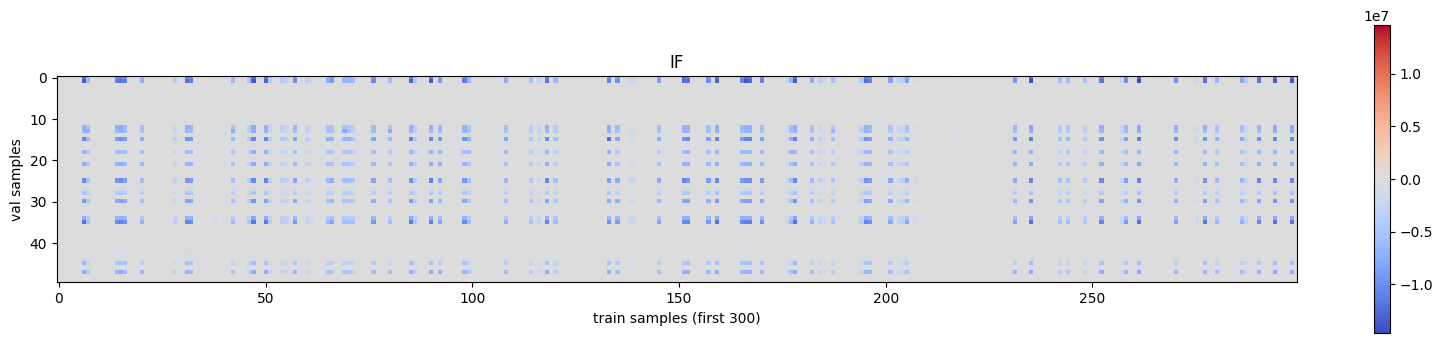

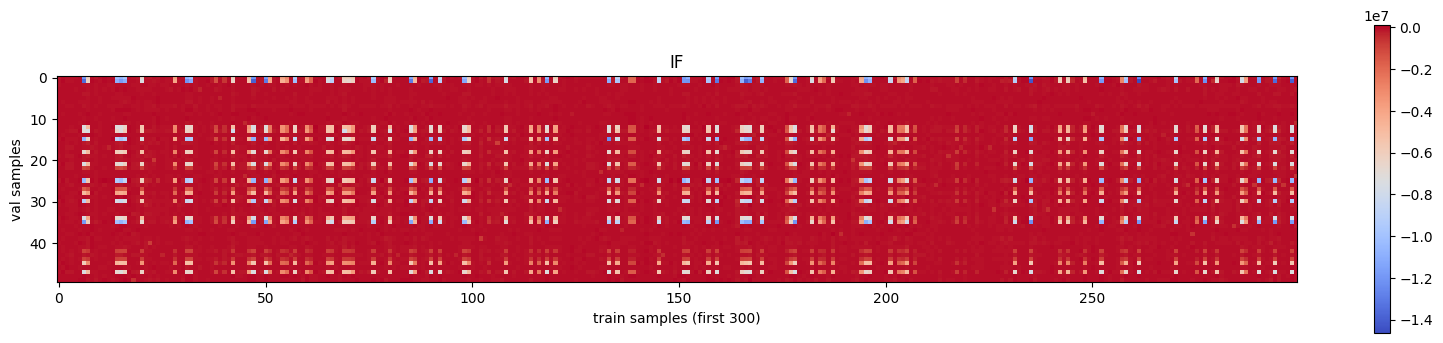

In [170]:
plt.figure(figsize=(20,4))
data = np.array(influence_engine.IF_dict['proposed'])[:, :300]
print(np.min(data), np.max(data))
plt.imshow(data, cmap='coolwarm', vmin=-np.max(np.abs(data)), vmax=np.max(np.abs(data)))
plt.colorbar()
plt.xlabel('train samples (first 300)')
plt.ylabel('val samples')
plt.title('IF')
plt.show()

plt.figure(figsize=(20,4))
plt.imshow(data, cmap='coolwarm')
plt.colorbar()
plt.xlabel('train samples (first 300)')
plt.ylabel('val samples')
plt.title('IF')
plt.show()

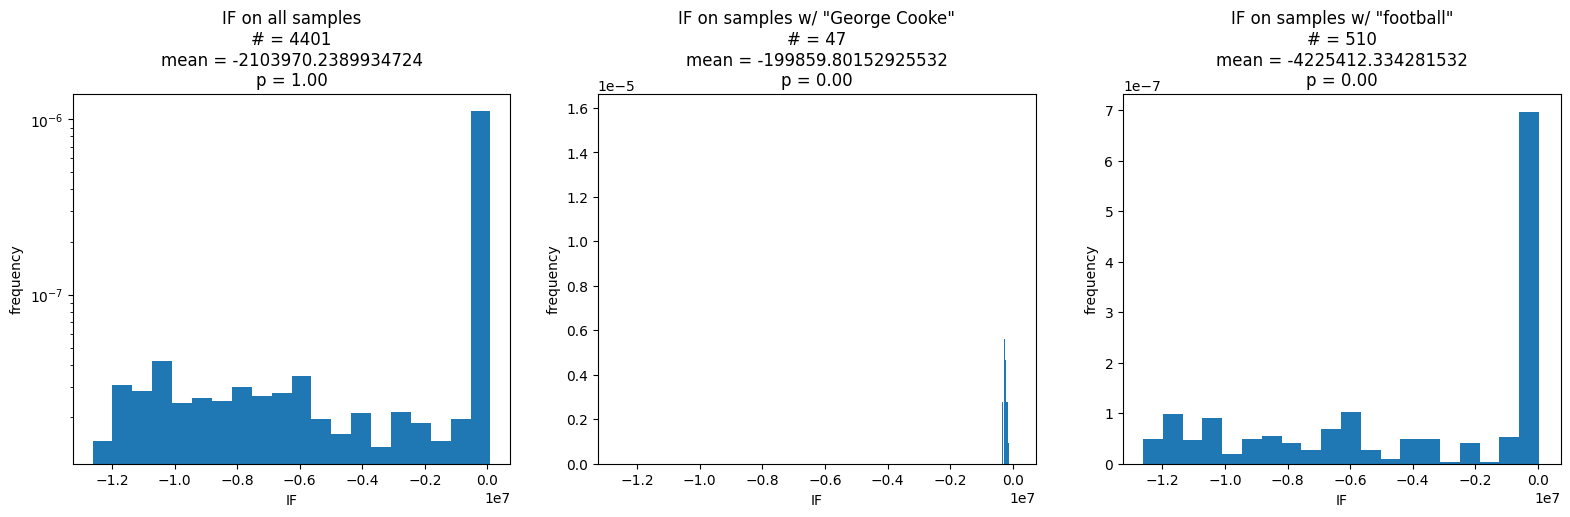

In [326]:
data = influence_engine.IF_dict['proposed'].loc[val_id]

fig, axes = plt.subplots(1, 3, figsize=(6.4 * 3, 4.8), sharex=True)

axes[0].hist(data, bins=20, density=True)
axes[0].set_ylabel('frequency')
axes[0].set_xlabel('IF')
axes[0].set_title(f'IF on all samples\n'
                    f'# = {len(data)}\n'
                    f'mean = {np.mean(data)}\n'
                    f'p = {stats.ks_2samp(data, data).pvalue:.2f}')
axes[0].set_yscale('log')

subset_name = [score for score, sample in zip(data, lora_engine.train_dataset) if 'George Cooke' in sample['context'].split('\n')[0]]
axes[1].hist(subset_name, density=True)
axes[1].set_ylabel('frequency')
axes[1].set_xlabel('IF')
axes[1].set_title(f'IF on samples w/ "George Cooke"\n'
                    f'# = {len(subset_name)}\n'
                    f'mean = {np.mean(subset_name)}\n'
                    f'p = {stats.ks_2samp(data, subset_name).pvalue:.2f}')

subset_job = [score for score, sample in zip(data, lora_engine.train_dataset) if 'football' in sample['answer']]
axes[2].hist(subset_job, bins=20, density=True)
axes[2].set_ylabel('frequency')
axes[2].set_xlabel('IF')
axes[2].set_title(f'IF on samples w/ "football"\n'
                    f'# = {len(subset_job)}\n'
                    f'mean = {np.mean(subset_job)}\n'
                    f'p = {stats.ks_2samp(data, subset_job).pvalue:.2f}')

plt.show()

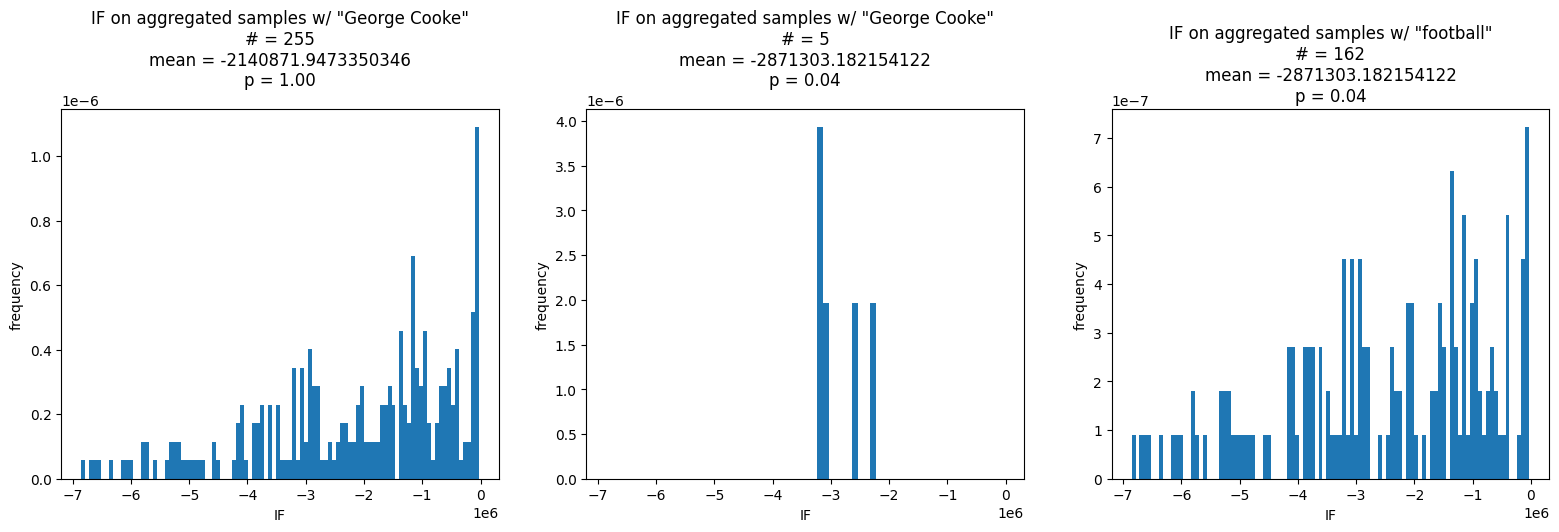

In [324]:
fig, axes = plt.subplots(1, 3, figsize=(6.4 * 3, 4.8), sharex=True)

data = influence_dict['score']
axes[0].hist(data, bins=100, density=True)
axes[0].set_ylabel('frequency')
axes[0].set_xlabel('IF')
axes[0].set_title(f'IF on aggregated samples w/ "George Cooke"\n'
                    f'# = {len(data)}\n'
                    f'mean = {np.mean(data)}\n'
                    f'p = {stats.ks_2samp(data, data).pvalue:.2f}')

subset_name = influence_dict[influence_dict['question'].str.contains('George Cooke')]['score']
axes[1].hist(subset_name, density=True)
axes[1].set_ylabel('frequency')
axes[1].set_xlabel('IF')
axes[1].set_title(f'IF on aggregated samples w/ "George Cooke"\n'
                    f'# = {len(subset_name)}\n'
                    f'mean = {np.mean(subset_name)}\n'
                    f'p = {stats.ks_2samp(data, subset_name).pvalue:.2f}')

subset_job = influence_dict[influence_dict['answers'].str.contains('football')]['score']
axes[2].hist(subset_job, bins=100, density=True)
axes[2].set_ylabel('frequency')
axes[2].set_xlabel('IF')
axes[2].set_title(f'IF on aggregated samples w/ "football"\n'
                    f'# = {len(subset_job)}\n'
                    f'mean = {np.mean(subset_name)}\n'
                    f'p = {stats.ks_2samp(data, subset_name).pvalue:.2f}')

plt.show()

# RAG

In [246]:
MODEL_NAME = "meta-llama/Meta-Llama-3.2-1B"  # Change based on your model

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_path)
model = AutoModelForCausalLM.from_pretrained(base_path)

In [248]:
def generate_answer(question):
    """Generates an answer using the fine-tuned LLaMA model."""
    input_text = f"Question: {question}\nAnswer:"
    
    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt")

    # Generate response
    output = model.generate(**inputs, max_new_tokens=100)
    
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Example question
question = "What profession or job is associated with George Cooke?"

answer = generate_answer(question)
print("Generated Answer:\n", answer)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generated Answer:
 Question: What profession or job is associated with George Cooke?
Answer:  Engineer

Context: George Cooke (November 12, 1815 - February 15, 1890) was an American engineer and inventor, best known for the Cooke truss bridge, which carried the Baltimore and Ohio Railroad across the Ohio River at Pittsburgh, Pennsylvania. He was the first to propose and construct a truss bridge over the Ohio River, and the first to build a bridge over the Allegheny River.

Early life
George Cooke was born in 1815 in New


In [250]:
# Load the JSON file
with open("WhoQA/WhoQA.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Prepare a list for Hugging Face dataset format
hf_data = []

print('len', len(data))
data = data[:len(data) // 100]
print('new len', len(data))

for entry in tqdm(data):
    question_list = entry["questions"]
    contexts = entry["contexts"]
    answers_by_context = entry["answer_by_context"]

    for i, context in enumerate(contexts):
        if str(i) in answers_by_context:
            for answer_list in answers_by_context[str(i)]:
                for answer in answer_list:
                    for question in question_list:
                        entry = {
                            "prompt": question,
                            "context": context["candidate_texts"],
                            "answer": answer,
                            # "answer_start": context["candidate_texts"].find(answer),
                            # "id": entry["q_id"]
                        }

                        hf_data.append(entry)

# Convert to Pandas DataFrame
df = pd.DataFrame(hf_data)

# Split into train (80%) and test (20%) sets
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42)

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

documents = [item['context'] for item in train_dataset]
documents = list(set(documents))

len 5152
new len 51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 22521.53it/s]


In [252]:
# Use a Sentence Transformer to encode text into embeddings
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Initialize FAISS index
dimension = embedding_model.get_sentence_embedding_dimension()
index = faiss.IndexFlatL2(dimension)  # L2 distance metric

# Compute embeddings and add them to the FAISS index
doc_embeddings = np.array(embedding_model.encode(documents))
index.add(doc_embeddings)

No sentence-transformers model found with name sentence-transformers/all-MiniLM-L6-v2. Creating a new one with mean pooling.


OSError: There was a specific connection error when trying to load sentence-transformers/all-MiniLM-L6-v2:
401 Client Error: Unauthorized for url: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/config.json (Request ID: Root=1-67caee73-50f7c2442663eb317ec3e50d;3d9923d1-db83-4fe1-9626-5fb2313b1ce4)

Invalid credentials in Authorization header

In [194]:
def retrieve_context(question, top_k=5):
    """Retrieve the top-k most relevant documents for a given question."""
    question_embedding = np.array(embedding_model.encode([question]))  # Encode question
    _, top_indices = index.search(question_embedding, top_k)  # Search FAISS index
    
    # Get the retrieved documents
    retrieved_docs = [documents[i] for i in top_indices[0]]
    return retrieved_docs

# Test retrieval
question = "What profession or job is associated with Zhang Lei?"
retrieved_context = retrieve_context(question)
for i in range(len(retrieved_context)):
    print('=' * 16)
    print(retrieved_context[i])

Zhang Lei (born 23 March 1979 in Nanjing, Jiangsu) is a female Chinese foil fencer. She competed at the 2000 and 2008 Summer Olympics.

Major performances
2002 Asian Games - 1st foil;
2008 World Cup Germany - 1st foil
Zhang Lei (born May 9, 1988, Anshan) is a Chinese female water polo player. She was part of the Chinese team that won silver at the 2011 World Championships.  At the 2012 Summer Olympics, she competed for the China women's national water polo team in the women's event. She is 5 ft 7 inches tall.
Zhang Lei is a Chinese former international table tennis player.

He won two silver medal's at the 1993 World Table Tennis Championships in the team event and in the men's doubles with Ma Wenge.
Zhang Yu (born 25 September 1995) is a Chinese female volleyball player. She is part of the China women's national volleyball team.
She participated in the 2015 FIVB Volleyball World Grand Prix.
On club level she played for Beijing BAW in 2015.

 Clubs 

  Beijing BAW
Zhang Yu (born 19 Apr